In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [9]:
train = pd.read_csv("./data/train.csv")  
test = pd.read_csv("./data/test.csv")

In [10]:
train.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


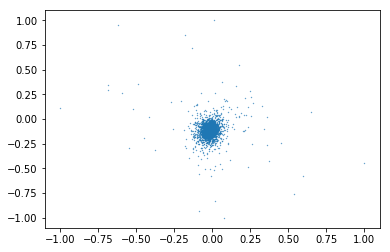

In [39]:
x_and_y=train.iloc[:,1:3]
plt.scatter(x_and_y['tBodyAcc-mean()-Y'], x_and_y['tBodyAcc-mean()-Z'], s=0.1)

In [28]:
print(train.columns.values)

['tBodyAcc-mean()-X' 'tBodyAcc-mean()-Y' 'tBodyAcc-mean()-Z'
 'tBodyAcc-std()-X' 'tBodyAcc-std()-Y' 'tBodyAcc-std()-Z'
 'tBodyAcc-mad()-X' 'tBodyAcc-mad()-Y' 'tBodyAcc-mad()-Z'
 'tBodyAcc-max()-X' 'tBodyAcc-max()-Y' 'tBodyAcc-max()-Z'
 'tBodyAcc-min()-X' 'tBodyAcc-min()-Y' 'tBodyAcc-min()-Z' 'tBodyAcc-sma()'
 'tBodyAcc-energy()-X' 'tBodyAcc-energy()-Y' 'tBodyAcc-energy()-Z'
 'tBodyAcc-iqr()-X' 'tBodyAcc-iqr()-Y' 'tBodyAcc-iqr()-Z'
 'tBodyAcc-entropy()-X' 'tBodyAcc-entropy()-Y' 'tBodyAcc-entropy()-Z'
 'tBodyAcc-arCoeff()-X,1' 'tBodyAcc-arCoeff()-X,2'
 'tBodyAcc-arCoeff()-X,3' 'tBodyAcc-arCoeff()-X,4'
 'tBodyAcc-arCoeff()-Y,1' 'tBodyAcc-arCoeff()-Y,2'
 'tBodyAcc-arCoeff()-Y,3' 'tBodyAcc-arCoeff()-Y,4'
 'tBodyAcc-arCoeff()-Z,1' 'tBodyAcc-arCoeff()-Z,2'
 'tBodyAcc-arCoeff()-Z,3' 'tBodyAcc-arCoeff()-Z,4'
 'tBodyAcc-correlation()-X,Y' 'tBodyAcc-correlation()-X,Z'
 'tBodyAcc-correlation()-Y,Z' 'tGravityAcc-mean()-X'
 'tGravityAcc-mean()-Y' 'tGravityAcc-mean()-Z' 'tGravityAcc-std()-X'
 'tGravi

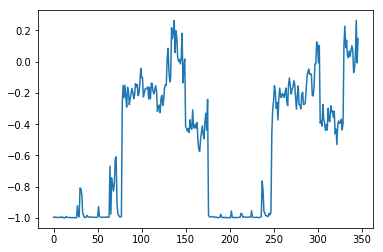

In [26]:
plt.plot(subj1["fBodyAcc-mean()-X"])
plt.show()

In [14]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
# lasso_model = linear_model.Lasso.path()
# print(train.drop('Activity',1))
classifier=KNeighborsClassifier(n_neighbors=5)
classifier.fit(train.drop('Activity',1),train.Activity)
                                 
# KNeighborsClassifier(train.drop('Activity',1), sk.preprocessing.LabelEncoder(train.Activity))

array(['STANDING', 'STANDING', 'STANDING', ..., 'WALKING_UPSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS'], dtype=object)

In [16]:
predicted=classifier.predict(test.drop('Activity',1))


In [24]:
correct=predicted==test.Activity
sum(correct)/len(correct)

0.8096369189005769

In [25]:
len(test.Activity)

2947